# Capstone Project - The Battle of Neighborhoods

## Business Problem Section

## Background

Many people want to invest their money in the business to make profits. There are different types of business like Restaurants,
Shopping Malls, and Departmental Stores etc. It is better to start their business in major cities in the country. In this project, I’d like to study the neighborhoods in Chennai,  
Tamil Nadu, India

## Business Problem

While starting a business, we need to search for a neighborhood that is suitable to their preferences. In this project, we study neighborhoods and venues to know which locality is good to set up a business.

The Foursquare API is used to access the venues in the neighborhoods. Since it returns fewer venues in the neighborhoods, we would be analyzing areas  
for which a countable number of venues are obtained. Then they are clustered based on their venues using Data Science Techniques. Here the k-means clustering algorithm is used to achieve the task. The optimal number of clusters  can be obtained using silhouette score metrics. Folium visualization library  
can be used to visualize the clusters superimposed on the map of Chennai city. These clusters can be analyzed to help small scale business owners select  
a suitable location for their need, such as Hotels, Shopping Malls, Restaurants, Departmental Stores and Coffee shops.

The major Target Audience would be small-scale business owners and stakeholders planning to start their business at a location in Chennai. This project would help them find the optimal location based on the category of their business such as,

•	What is the best location to start a Restaurant in Chennai?

•	Which area is best suitable for opening a Shopping Mall and a Departmental Store in Chennai?

In [35]:
import re
import json
import requests
import numpy as np
from bs4 import BeautifulSoup

import pandas as pd
#display all rows
pd.set_option('display.max_rows', None)
#display all columns
pd.set_option('display.max_columns', None)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from geopy.geocoders import Nominatim

import folium

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

print('Libraries imported.')

Libraries imported.


## Data Requirements

Chennai has multiple neighborhoods. The chennaiiq.com website has a dataset which has the list of neighborhoods in Chennai along with their Latitude and Longitude. Foursquare API is used to obtain the venue details in each neighborhood.

1.  https://chennaiiq.com/chennai/latitude_longitude_areas.asp
2.  https://www.foursquare.com

But the Latitude and Longitude data provided here is in Degrees Minute Seconds format. Thus before starting the analysis, the location data has to be converted to Decimal Degrees. First,. lets access the html file.

In [36]:
url = 'https://chennaiiq.com/chennai/latitude_longitude_areas.asp'

html = requests.get(url)
print(html)

<Response [200]>


A Reponse value of 200 means that the process was successful. Now we need to clean the file to access the Neighborhoods and their Locations. Lets use BeautifulSoup library to parse the html file in order to make it easier to access.

In [37]:
soup = BeautifulSoup(html.text, 'html.parser')
table = soup.find("table", attrs={"class": "TBox"})

The html has been parsed and it can be used to build the dataset. Let us access the Location data and store it in a pandas dataframe, chennai_data.

### Data Collection:

In [38]:
table_data = []
index = ['S.No.', 'Location', 'Latitude', 'Longitude']
for tr in table.find_all("tr", attrs={"class": "tab"}):
    t_row = {}
    for td, th in zip(tr.find_all("td"), index): 
        t_row[th] = td.text.replace('\n', '').strip()
    table_data.append(t_row)

chennai_data = pd.DataFrame(table_data[:-1], columns=index)
chennai_data.drop(columns=['S.No.'], inplace=True)
chennai_data.at[0,'Location'] = 'Adyar Bus Debot'
chennai_data.rename(columns={'Location': 'Neighborhood'}, inplace=True)
print(chennai_data.shape)
chennai_data.head()

(105, 3)


,Neighborhood,Latitude,Longitude
0,Adyar Bus Debot,"12°59'50"" N","80°15'25"" E"
1,Adyar Signal,"13°00'23"" N","80°15'27"" E"
2,Alandur,"13°00'28"" N","80°12'35"" E"
3,Ambattur,"13°06'36"" N","80°10'12"" E"
4,Anna Arch,"13°04'28"" N","80°13'06"" E"


### Convert Degrees Minute Seconds to Decimal Degrees

There are a total of 105 neighborhoods. But as said earlier the Latitude and Longitude data needs to be converted Degrees Minute Seconds to Decimal Degrees. The dms2dd fucntion defined below will solve this problem.

In [39]:
def dms2dd(s):
    degrees, minutes, seconds, direction = re.split('[°\'"]+', s)
    dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60);
    if direction in ('S','W'):
        dd*= -1
    return dd

chennai_data['Latitude'] = chennai_data['Latitude'].apply(dms2dd)
chennai_data['Longitude'] = chennai_data['Longitude'].apply(dms2dd)
print(chennai_data.shape)
chennai_data.head()

(105, 3)


,Neighborhood,Latitude,Longitude
0,Adyar Bus Debot,12.997222,80.256944
1,Adyar Signal,13.006389,80.257500
2,Alandur,13.007778,80.209722
3,Ambattur,13.110000,80.170000
4,Anna Arch,13.074444,80.218333


Now that we have the neighborhoods dataset lets visualize them using Folium Library. First lets create a map of Chennai. The latitude and longitude of chennai can be obtained using the Geolocator library.

In [40]:
address = 'Chennai, Tamil Nadu'

geolocator = Nominatim(user_agent="chennai_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of chennai are {}, {}.'.format(latitude, longitude))

The geographical coordinate of chennai are 13.0836939, 80.270186.


### Chennai Map:

In [41]:
# create map of Toronto using latitude and longitude values
chennai_map = folium.Map(location=[latitude, longitude], zoom_start=11)    
chennai_map

### Chennai Map with the neighborhoods superimposed on top:

In [42]:
# add neighborhood markers to map
for lat, lng, location in zip(chennai_data['Latitude'], chennai_data['Longitude'], chennai_data['Neighborhood']):
    label = '{}'.format(location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(chennai_map)  

chennai_map

### Define Foursquare Credentials and Version

In [43]:
CLIENT_ID = 'FXW45F0JDJVAXMSJSJWDHICQU5AG0WAAL4KPGOJH13N3KJT3' # your Foursquare ID
CLIENT_SECRET = 'KBROYNJZCHFM43T12HXBCT05YSO14XFK54UPHBXVR0BO3RYL' # your Foursquare Secret
VERSION = '20210609' # Foursquare API version

### Explore neighborhoods in Chennai

The following function will send a explore request for each neighborhood and return the 100 most popular places in the neighborhood around 500 meters.

In [44]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, limit=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        count = 1
        while count != 5:
            try:
                results = requests.get(url).json()["response"]['groups'][0]['items']
                count = 5
            except:
                count += 1
    
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Lets use the above function on the chennai_data neighborhoods dataframe and store the venues data returned in the chennai_venues pandas dataframe.

In [45]:
chennai_venues = getNearbyVenues(names = chennai_data['Neighborhood'],
                                 latitudes = chennai_data['Latitude'],
                                 longitudes = chennai_data['Longitude']
                                 )

print(chennai_venues.shape)
chennai_venues.head()

(1009, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adyar Bus Debot,12.997222,80.256944,Zaitoon Restaurant,12.996861,80.256178,Middle Eastern Restaurant
1,Adyar Bus Debot,12.997222,80.256944,Zha Cafe,12.999730,80.254806,Café
2,Adyar Bus Debot,12.997222,80.256944,Kuttanadu Restaurant,12.997010,80.257799,Asian Restaurant
3,Adyar Bus Debot,12.997222,80.256944,Barbeque N Biryani,12.995907,80.256011,BBQ Joint
4,Adyar Bus Debot,12.997222,80.256944,Domino's Pizza,13.001470,80.256626,Pizza Place


A total of 1009 venues were obtained. Now lets check the number of venues returned per neighborhood.

In [46]:
chennai_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
AVM Studio,5,5,5,5,5,5
Adyar Bus Debot,11,11,11,11,11,11
Adyar Signal,22,22,22,22,22,22
Alandur,9,9,9,9,9,9
Ambattur,2,2,2,2,2,2
Anna Arch,10,10,10,10,10,10
Anna Nagar Roundana,19,19,19,19,19,19
Anna Nagar West Terminus,9,9,9,9,9,9
Anna Statue,11,11,11,11,11,11


From the above dataframe we can see that Taj Coromandal returned the highest number of venues i.e. 50. Now lets check the unique categories of all the venues returned.

In [47]:
print('There are {} uniques categories.'.format(len(chennai_venues['Venue Category'].unique())))

There are 136 uniques categories.


## Methodology 

Now, we have the neighborhoods data of chennai **(105 neighborhoods)**. We also have the most popular venues in each neighborhood obtained using Foursquare API. A total of **1009 venues** have been obtained in the whole city and **136 unique categories**. But as seen we have multiple neighborhoods  
with less than 10 venues returned. In order to create a good analysis let's consider only the **neighborhoods with more than 10 venues**.

We can perform one hot encoding on the obtained data set and use it find the 10 most common venue category in each neighborhood. Then clustering  
can be performed on the dataset. Here K - Nearest Neighbor clustering technique have been used. To find the optimal number of clusters silhouette score metric technique is used.

The clusters obtained can be analyzed to find the major type of venue categories in each cluster. This data can be used to suggest business people, suitable locations based on the category.

## Analysis 

First, lets visualize the number of venues obtained in all the neighborhoods of Chennai.

<AxesSubplot:xlabel='Neighborhood'>

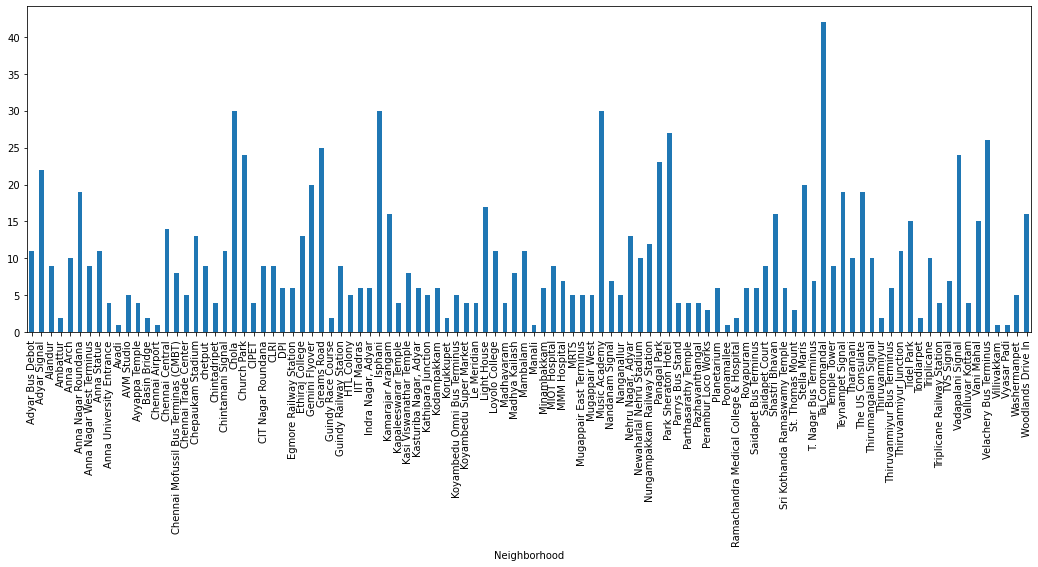

In [48]:
df = chennai_venues.groupby(['Neighborhood'], sort=False)['Venue'].count()
df.plot.bar(figsize=(18,6))

As we can see from the above bar chart, there are many neighborhoods with less than 10 venues which can be remove before performing the analysis to obtain better results. The following plot shows only the neighborhoods from which 10 or more than 10 venues were obtained.

<AxesSubplot:xlabel='Neighborhood'>

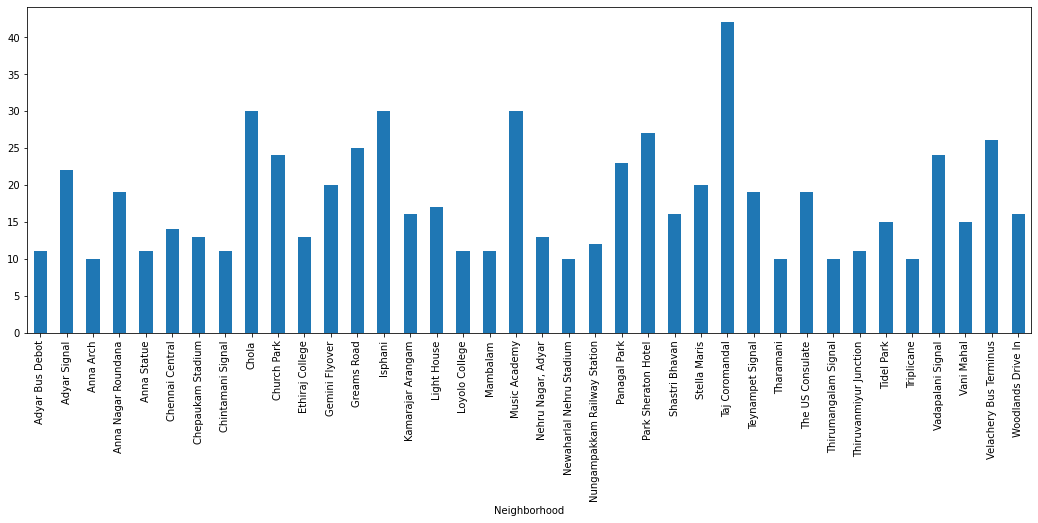

In [49]:
df = df[df >= 10]
df.plot.bar(figsize=(18,6))

Lets create a new dataframe, chennai_venues_top that contains only the neighborhoods with 10+ venues and the venues with their details included.

In [50]:
chennai_venues_top = chennai_venues[chennai_venues['Neighborhood'].isin(df.index.tolist())]
chennai_venues_top.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adyar Bus Debot,12.997222,80.256944,Zaitoon Restaurant,12.996861,80.256178,Middle Eastern Restaurant
1,Adyar Bus Debot,12.997222,80.256944,Zha Cafe,12.999730,80.254806,Café
2,Adyar Bus Debot,12.997222,80.256944,Kuttanadu Restaurant,12.997010,80.257799,Asian Restaurant
3,Adyar Bus Debot,12.997222,80.256944,Barbeque N Biryani,12.995907,80.256011,BBQ Joint
4,Adyar Bus Debot,12.997222,80.256944,Domino's Pizza,13.001470,80.256626,Pizza Place


### One hot encoding

In [51]:
chennai_onehot = pd.get_dummies(chennai_venues_top['Venue Category'], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
chennai_onehot['Neighborhood'] = chennai_venues_top['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = chennai_onehot.columns.tolist()
fixed_columns.insert(0, fixed_columns.pop(fixed_columns.index('Neighborhood')))
chennai_onehot = chennai_onehot.reindex(columns = fixed_columns)

print(chennai_onehot.shape)
chennai_onehot.head()

(676, 94)


,Neighborhood,African Restaurant,American Restaurant,Amphitheater,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Beach,Bike Shop,Bistro,Bookstore,Boutique,Breakfast Spot,Bus Station,Business Service,Café,Camera Store,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Department Store,Dessert Shop,Donut Shop,Eastern European Restaurant,Electronics Store,Fast Food Restaurant,Flea Market,Food Court,Gaming Cafe,General Entertainment,Gourmet Shop,Gym / Fitness Center,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indian Sweet Shop,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Kerala Restaurant,Lounge,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Movie Theater,Multicuisine Indian Restaurant,Multiplex,Music Store,Nightclub,North Indian Restaurant,Office,Paper / Office Supplies Store,Park,Pharmacy,Pizza Place,Platform,Print Shop,Pub,Ramen Restaurant,Recreation Center,Restaurant,Rock Club,Russian Restaurant,Salon / Barbershop,Sandwich Place,Sculpture Garden,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Soccer Stadium,South American Restaurant,South Indian Restaurant,Spa,Steakhouse,Tea Room,Thai Restaurant,Theater,Train Station,Vegetarian / Vegan Restaurant,Women's Store
0,Adyar Bus Debot,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Adyar Bus Debot,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Adyar Bus Debot,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Adyar Bus Debot,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Adyar Bus Debot,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Lets group the data by neighborhood and taking the mean value of the frequency of occurrence of each category.

In [52]:
chennai_grouped = chennai_onehot.groupby('Neighborhood').mean().reset_index()
print(chennai_grouped.shape)
chennai_grouped.head()

(38, 94)


,Neighborhood,African Restaurant,American Restaurant,Amphitheater,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Beach,Bike Shop,Bistro,Bookstore,Boutique,Breakfast Spot,Bus Station,Business Service,Café,Camera Store,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Department Store,Dessert Shop,Donut Shop,Eastern European Restaurant,Electronics Store,Fast Food Restaurant,Flea Market,Food Court,Gaming Cafe,General Entertainment,Gourmet Shop,Gym / Fitness Center,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indian Sweet Shop,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Kerala Restaurant,Lounge,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Movie Theater,Multicuisine Indian Restaurant,Multiplex,Music Store,Nightclub,North Indian Restaurant,Office,Paper / Office Supplies Store,Park,Pharmacy,Pizza Place,Platform,Print Shop,Pub,Ramen Restaurant,Recreation Center,Restaurant,Rock Club,Russian Restaurant,Salon / Barbershop,Sandwich Place,Sculpture Garden,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Soccer Stadium,South American Restaurant,South Indian Restaurant,Spa,Steakhouse,Tea Room,Thai Restaurant,Theater,Train Station,Vegetarian / Vegan Restaurant,Women's Store
0,Adyar Bus Debot,0.0,0.000000,0.0,0.181818,0.090909,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.090909,0.0,0.0,0.090909,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.090909,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.181818,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,Adyar Signal,0.0,0.045455,0.0,0.000000,0.000000,0.090909,0.0,0.0,0.0,0.045455,0.0,0.045455,0.0,0.000000,0.0,0.0,0.045455,0.0,0.0,0.0,0.000000,0.045455,0.0,0.0,0.0,0.0,0.045455,0.0,0.0,0.045455,0.045455,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.318182,0.0,0.0,0.0,0.0,0.045455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.090909,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.045455,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.045455,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,Anna Arch,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.100000,0.0,0.000000,0.0,0.0,0.100000,0.0,0.0,0.0,0.200000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.100000,0.200000,0.000000,0.1,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.100000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.100000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,Anna Nagar Roundana,0.0,0.000000,0.0,0.052632,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.052632,0.0,0.000000,0.0,0.0,0.052632,0.0,0.0,0.0,0.105263,0.052632,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.052632,0.052632,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.052632,0.0,0.263158,0.0,0.0,0.0,0.0,0.052632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.052632,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.052632,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.052632,0.0,0.0,0.0,0.0,0.0,0.0,0.052632,0.0
4,Anna Statue,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.090909,0.0,0.0,0.000000,0.000000,0.090909,0.0,0.0,0.090909,0.0,0.0,0.0,0.000000,0.0,0.363636,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.090909,0.0,0.272727,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0

The following function returns the top_venues of each neighborhood.

In [53]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Lets use the above function to obtaine the 10 most common venues in each neighborhood and store in the new pandas dataframe **neighborhoods_venues_sorted**.

In [54]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create column names according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = chennai_grouped['Neighborhood']

for ind in np.arange(chennai_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chennai_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adyar Bus Debot,Asian Restaurant,Indian Restaurant,Pizza Place,Sandwich Place,BBQ Joint,Fast Food Restaurant,Middle Eastern Restaurant,Café,Breakfast Spot,Department Store
1,Adyar Signal,Indian Restaurant,North Indian Restaurant,Bakery,Coffee Shop,Snack Place,Fast Food Restaurant,Electronics Store,Dessert Shop,Rock Club,Café
2,Anna Arch,Clothing Store,Fast Food Restaurant,Bookstore,Food Court,Electronics Store,Café,Multiplex,Pizza Place,Gym / Fitness Center,Indian Restaurant
3,Anna Nagar Roundana,Indian Restaurant,Clothing Store,Bookstore,Hotel Bar,Coffee Shop,Electronics Store,Fast Food Restaurant,Café,Middle Eastern Restaurant,Paper / Office Supplies Store
4,Anna Statue,Indian Restaurant,Multiplex,Movie Theater,Dessert Shop,Flea Market,General Entertainment,Department Store,Donut Shop,Eastern European Restaurant,Electronics Store


### Cluster Neighborhoods

Here k-Nearest Neighborhoods clustering technique is used. Lets use the **silhouette_score** to obtain the best value for the number of clusters.

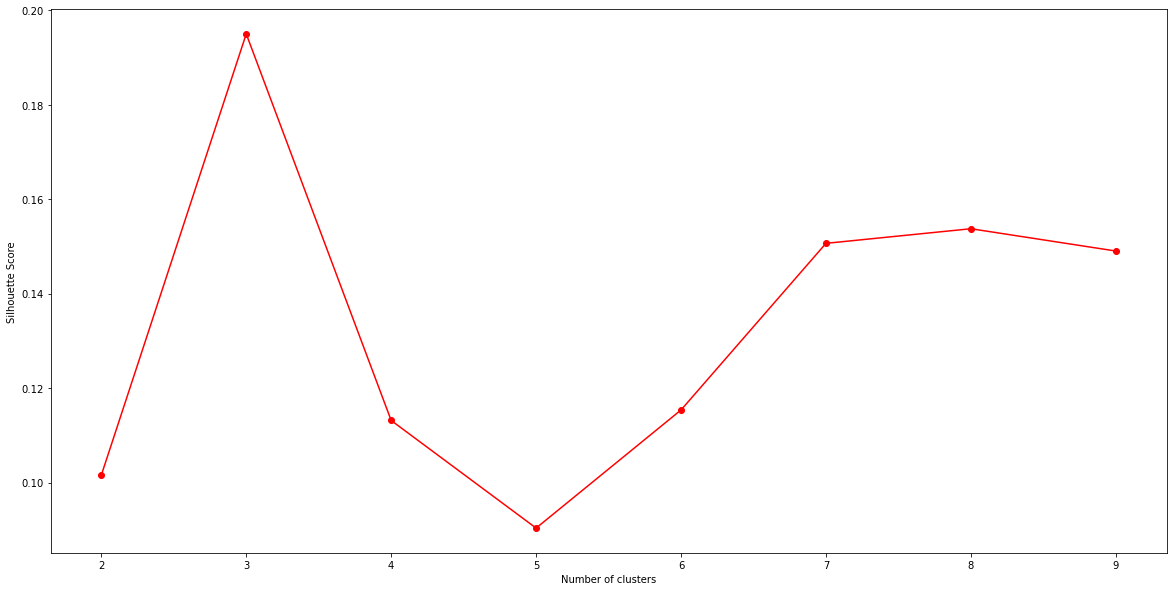

In [55]:
chennai_grouped_clustering = chennai_grouped.drop('Neighborhood', 1)

max_score = 10
scores = []

for kclusters in range(2, max_score):
    # Run k-means clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(chennai_grouped_clustering)
    
    # Gets the silhouette score
    score = silhouette_score(chennai_grouped_clustering, kmeans)
    scores.append(score)

plt.figure(figsize=(20,10))
plt.plot(np.arange(2, max_score), scores, 'ro-')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.xticks(np.arange(2, max_score))
plt.show()

As seen from the above line plot, the best number of clusters having the highest silhouette score is 2 but we consider 8 clusters.

In [56]:
# select best number of clusters
kclusters = 9

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(chennai_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 3, 0, 2, 1, 0, 0, 1, 1])

Add the cluster labels to the **neighborhoods_venues_sorted** dataframe. And lets create a new datframe **chennai_merged** which has the neighborhood details, cluster labels and the 10 most common venues in that neighborhood.

In [57]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

chennai_merged = chennai_venues_top[chennai_venues_top.columns[0:3]].drop_duplicates()
chennai_merged.reset_index(drop = True, inplace = True)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
chennai_merged = chennai_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

chennai_merged.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adyar Bus Debot,12.997222,80.256944,0,Asian Restaurant,Indian Restaurant,Pizza Place,Sandwich Place,BBQ Joint,Fast Food Restaurant,Middle Eastern Restaurant,Café,Breakfast Spot,Department Store
1,Adyar Signal,13.006389,80.257500,0,Indian Restaurant,North Indian Restaurant,Bakery,Coffee Shop,Snack Place,Fast Food Restaurant,Electronics Store,Dessert Shop,Rock Club,Café
2,Anna Arch,13.074444,80.218333,3,Clothing Store,Fast Food Restaurant,Bookstore,Food Court,Electronics Store,Café,Multiplex,Pizza Place,Gym / Fitness Center,Indian Restaurant
3,Anna Nagar Roundana,13.084444,80.218056,0,Indian Restaurant,Clothing Store,Bookstore,Hotel Bar,Coffee Shop,Electronics Store,Fast Food Restaurant,Café,Middle Eastern Restaurant,Paper / Office Supplies Store
4,Anna Statue,13.068056,80.271944,2,Indian Restaurant,Multiplex,Movie Theater,Dessert Shop,Flea Market,General Entertainment,Department Store,Donut Shop,Eastern European Restaurant,Electronics Store


## Results 

Let’s examine the clusters and find the discriminating venue categories that distinguish each cluster. For this purpose lets also print the ten most common venue category in each cluster.

### Cluster 1

In [58]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 0, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adyar Bus Debot,Asian Restaurant,Indian Restaurant,Pizza Place,Sandwich Place,BBQ Joint,Fast Food Restaurant,Middle Eastern Restaurant,Café,Breakfast Spot,Department Store
1,Adyar Signal,Indian Restaurant,North Indian Restaurant,Bakery,Coffee Shop,Snack Place,Fast Food Restaurant,Electronics Store,Dessert Shop,Rock Club,Café
3,Anna Nagar Roundana,Indian Restaurant,Clothing Store,Bookstore,Hotel Bar,Coffee Shop,Electronics Store,Fast Food Restaurant,Café,Middle Eastern Restaurant,Paper / Office Supplies Store
6,Chepaukam Stadium,Indian Restaurant,Electronics Store,Bookstore,Multiplex,Hotel,Bar,General Entertainment,Café,Music Store,Dessert Shop
7,Chintamani Signal,Indian Restaurant,Restaurant,Coffee Shop,Dessert Shop,Bakery,Middle Eastern Restaurant,Smoke Shop,Shoe Store,Flea Market,Convenience Store
20,Newaharlal Nehru Stadium,Indian Restaurant,Bookstore,Soccer Stadium,Café,Sandwich Place,Platform,Vegetarian / Vegan Restaurant,Hotel Bar,Hotel,Convenience Store
24,Shastri Bhavan,Indian Restaurant,Chinese Restaurant,Japanese Restaurant,Hotel,Coffee Shop,Fast Food Restaurant,Multicuisine Indian Restaurant,Pizza Place,Convenience Store,Asian Restaurant
26,Taj Coromandal,Indian Restaurant,Sandwich Place,Chinese Restaurant,Café,Ice Cream Shop,Asian Restaurant,Dessert Shop,Italian Restaurant,Clothing Store,Park
36,Velachery Bus Terminus,Indian Restaurant,Fast Food Restaurant,Pizza Place,Clothing Store,Coffee Shop,Department Store,Chinese Restaurant,Ramen Restaurant,Restaurant,Multiplex


In [59]:
cluster1 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 0, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues1 = (cluster1['1st Most Common Venue'].append(
    cluster1['2nd Most Common Venue']).append(
    cluster1['3rd Most Common Venue']).append(
    cluster1['4th Most Common Venue']).append(
    cluster1['5th Most Common Venue']).append(
    cluster1['6th Most Common Venue']).append(
    cluster1['7th Most Common Venue']).append(
    cluster1['8th Most Common Venue']).append(
    cluster1['9th Most Common Venue']).append(
    cluster1['10th Most Common Venue']))

print(venues1.value_counts().head(10))

Indian Restaurant       9
Café                    6
Coffee Shop             5
Fast Food Restaurant    5
Dessert Shop            4
Sandwich Place          3
Electronics Store       3
Asian Restaurant        3
Convenience Store       3
Pizza Place             3
dtype: int64


### Cluster 2

In [60]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 1, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Chennai Central,Indian Restaurant,Bookstore,Train Station,Sandwich Place,Vegetarian / Vegan Restaurant,Platform,Hotel,Metro Station,Nightclub,Bus Station
8,Chola,Indian Restaurant,Hotel,Restaurant,African Restaurant,Russian Restaurant,Italian Restaurant,Juice Bar,Vegetarian / Vegan Restaurant,Kerala Restaurant,Lounge
9,Church Park,Chinese Restaurant,Indian Restaurant,Movie Theater,Multiplex,Bakery,Café,Middle Eastern Restaurant,Pub,Gaming Cafe,Pizza Place
12,Greams Road,Indian Restaurant,Café,Juice Bar,Middle Eastern Restaurant,Movie Theater,Multiplex,Chinese Restaurant,Vegetarian / Vegan Restaurant,Gaming Cafe,Mexican Restaurant
18,Music Academy,Indian Restaurant,Hotel,Restaurant,Café,Women's Store,Russian Restaurant,Bank,Bar,Chinese Restaurant,Comfort Food Restaurant
25,Stella Maris,Indian Restaurant,Hotel,Women's Store,Sandwich Place,Bar,Camera Store,Chinese Restaurant,Ice Cream Shop,Italian Restaurant,Jewelry Store
27,Teynampet Signal,Indian Restaurant,Hotel,Italian Restaurant,Lounge,Pub,Pizza Place,Café,Juice Bar,Mediterranean Restaurant,Gym / Fitness Center
31,Thiruvanmiyur Junction,Juice Bar,Indian Restaurant,Pizza Place,Multiplex,Vegetarian / Vegan Restaurant,Indian Sweet Shop,Pharmacy,Hotel,Chinese Restaurant,Department Store
34,Vadapalani Signal,Indian Restaurant,Hotel,Fast Food Restaurant,Asian Restaurant,Multiplex,South Indian Restaurant,Market,Shopping Mall,Music Store,Clothing Store
35,Vani Mahal,Indian Restaurant,Hotel,Coffee Shop,Vegetarian / Vegan Restaurant,BBQ Joint,Department Store,Hotel Bar,South American Restaurant,Pub,Boutique


In [61]:
cluster2 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 1, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues2 = (cluster2['1st Most Common Venue'].append(
    cluster2['2nd Most Common Venue']).append(
    cluster2['3rd Most Common Venue']).append(
    cluster2['4th Most Common Venue']).append(
    cluster2['5th Most Common Venue']).append(
    cluster2['6th Most Common Venue']).append(
    cluster2['7th Most Common Venue']).append(
    cluster2['8th Most Common Venue']).append(
    cluster2['9th Most Common Venue']).append(
    cluster2['10th Most Common Venue']))

print(venues2.value_counts().head(10))

Indian Restaurant                10
Hotel                             8
Vegetarian / Vegan Restaurant     5
Chinese Restaurant                5
Café                              4
Juice Bar                         4
Multiplex                         4
Pizza Place                       3
Italian Restaurant                3
Pub                               3
dtype: int64


### Cluster 3

In [62]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 2, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Anna Statue,Indian Restaurant,Multiplex,Movie Theater,Dessert Shop,Flea Market,General Entertainment,Department Store,Donut Shop,Eastern European Restaurant,Electronics Store
33,Triplicane,Indian Restaurant,Multiplex,General Entertainment,Dessert Shop,Gaming Cafe,Department Store,Donut Shop,Eastern European Restaurant,Electronics Store,Fast Food Restaurant


In [63]:
cluster3 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 2, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues3 = (cluster3['1st Most Common Venue'].append(
    cluster3['2nd Most Common Venue']).append(
    cluster3['3rd Most Common Venue']).append(
    cluster3['4th Most Common Venue']).append(
    cluster3['5th Most Common Venue']).append(
    cluster3['6th Most Common Venue']).append(
    cluster3['7th Most Common Venue']).append(
    cluster3['8th Most Common Venue']).append(
    cluster3['9th Most Common Venue']).append(
    cluster3['10th Most Common Venue']))

print(venues3.value_counts().head(10))

Eastern European Restaurant    2
Department Store               2
Multiplex                      2
Indian Restaurant              2
Electronics Store              2
Dessert Shop                   2
General Entertainment          2
Donut Shop                     2
Movie Theater                  1
Fast Food Restaurant           1
dtype: int64


### Cluster 4

In [64]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 3, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Anna Arch,Clothing Store,Fast Food Restaurant,Bookstore,Food Court,Electronics Store,Café,Multiplex,Pizza Place,Gym / Fitness Center,Indian Restaurant
28,Tharamani,Fast Food Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,Office,Hotel,Café,Sandwich Place,Food Court,Women's Store,Department Store
32,Tidel Park,Food Court,Fast Food Restaurant,Café,Sandwich Place,Platform,Bus Station,Vegetarian / Vegan Restaurant,Indian Restaurant,Office,Convenience Store


In [65]:
cluster4 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 3, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues4 = (cluster4['1st Most Common Venue'].append(
    cluster4['2nd Most Common Venue']).append(
    cluster4['3rd Most Common Venue']).append(
    cluster4['4th Most Common Venue']).append(
    cluster4['5th Most Common Venue']).append(
    cluster4['6th Most Common Venue']).append(
    cluster4['7th Most Common Venue']).append(
    cluster4['8th Most Common Venue']).append(
    cluster4['9th Most Common Venue']).append(
    cluster4['10th Most Common Venue']))

print(venues4.value_counts().head(10))

Café                             3
Indian Restaurant                3
Fast Food Restaurant             3
Food Court                       3
Vegetarian / Vegan Restaurant    2
Sandwich Place                   2
Office                           2
Department Store                 1
Clothing Store                   1
Hotel                            1
dtype: int64


### Cluster 5

In [70]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 4, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,Mambalam,Clothing Store,Jewelry Store,Indian Restaurant,Boutique,Asian Restaurant,South Indian Restaurant,Snack Place,Department Store,Dessert Shop,Donut Shop
22,Panagal Park,Indian Restaurant,Clothing Store,South Indian Restaurant,Jewelry Store,Women's Store,Pizza Place,Concert Hall,Coffee Shop,Boutique,Dessert Shop


In [71]:
cluster5 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 4, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues5 = (cluster5['1st Most Common Venue'].append(
    cluster5['2nd Most Common Venue']).append(
    cluster5['3rd Most Common Venue']).append(
    cluster5['4th Most Common Venue']).append(
    cluster5['5th Most Common Venue']).append(
    cluster5['6th Most Common Venue']).append(
    cluster5['7th Most Common Venue']).append(
    cluster5['8th Most Common Venue']).append(
    cluster5['9th Most Common Venue']).append(
    cluster5['10th Most Common Venue']))

print(venues5.value_counts().head(10))

Indian Restaurant          2
Boutique                   2
Jewelry Store              2
Clothing Store             2
Dessert Shop               2
South Indian Restaurant    2
Donut Shop                 1
Snack Place                1
Women's Store              1
Asian Restaurant           1
dtype: int64


### Cluster 6

In [72]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 5, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Loyolo College,Women's Store,Train Station,Vegetarian / Vegan Restaurant,Department Store,Indian Restaurant,Ice Cream Shop,Clothing Store,South Indian Restaurant,Chinese Restaurant,Mexican Restaurant
21,Nungampakkam Railway Station,Department Store,Women's Store,Train Station,Vegetarian / Vegan Restaurant,Indian Restaurant,Ice Cream Shop,Clothing Store,South Indian Restaurant,Chinese Restaurant,Mexican Restaurant


In [73]:
cluster6 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 5, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues6 = (cluster6['1st Most Common Venue'].append(
    cluster6['2nd Most Common Venue']).append(
    cluster6['3rd Most Common Venue']).append(
    cluster6['4th Most Common Venue']).append(
    cluster6['5th Most Common Venue']).append(
    cluster6['6th Most Common Venue']).append(
    cluster6['7th Most Common Venue']).append(
    cluster6['8th Most Common Venue']).append(
    cluster6['9th Most Common Venue']).append(
    cluster6['10th Most Common Venue']))

print(venues6.value_counts().head(10))

Department Store                 2
Ice Cream Shop                   2
Train Station                    2
Indian Restaurant                2
Chinese Restaurant               2
Mexican Restaurant               2
Women's Store                    2
Clothing Store                   2
Vegetarian / Vegan Restaurant    2
South Indian Restaurant          2
dtype: int64


### Cluster 7

In [74]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 6, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Ethiraj College,Hotel,Kebab Restaurant,Restaurant,Indian Restaurant,Middle Eastern Restaurant,Fast Food Restaurant,Donut Shop,Pizza Place,Juice Bar,Asian Restaurant
11,Gemini Flyover,Hotel,Sandwich Place,Nightclub,Coffee Shop,Concert Hall,Bar,Café,Chinese Restaurant,Pizza Place,South Indian Restaurant
13,Isphani,Indian Restaurant,Hotel,Nightclub,Sandwich Place,Chinese Restaurant,Coffee Shop,South Indian Restaurant,Pizza Place,Bar,Pub
14,Kamarajar Arangam,Hotel,Café,Indian Restaurant,Pizza Place,Concert Hall,Amphitheater,Ice Cream Shop,Lounge,Park,South Indian Restaurant
23,Park Sheraton Hotel,Café,Restaurant,Italian Restaurant,Indian Restaurant,Thai Restaurant,Hotel,Coffee Shop,Sandwich Place,Japanese Restaurant,Dessert Shop
29,The US Consulate,Hotel,Sandwich Place,Nightclub,Coffee Shop,Electronics Store,Café,Chinese Restaurant,Bar,Park,South Indian Restaurant
37,Woodlands Drive In,Hotel,Indian Restaurant,Nightclub,Coffee Shop,Electronics Store,Park,Thai Restaurant,Ice Cream Shop,South Indian Restaurant,Bar


In [75]:
cluster7 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 6, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues7 = (cluster7['1st Most Common Venue'].append(
    cluster7['2nd Most Common Venue']).append(
    cluster7['3rd Most Common Venue']).append(
    cluster7['4th Most Common Venue']).append(
    cluster7['5th Most Common Venue']).append(
    cluster7['6th Most Common Venue']).append(
    cluster7['7th Most Common Venue']).append(
    cluster7['8th Most Common Venue']).append(
    cluster7['9th Most Common Venue']).append(
    cluster7['10th Most Common Venue']))

print(venues7.value_counts().head(10))

Hotel                      7
Coffee Shop                5
South Indian Restaurant    5
Indian Restaurant          5
Café                       4
Sandwich Place             4
Pizza Place                4
Bar                        4
Nightclub                  4
Chinese Restaurant         3
dtype: int64


### Cluster 8

In [76]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 7, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,"Nehru Nagar, Adyar",Café,Indian Restaurant,Chinese Restaurant,Pizza Place,Juice Bar,Ice Cream Shop,Sandwich Place,Flea Market,Department Store,Dessert Shop
30,Thirumangalam Signal,Indian Restaurant,Pizza Place,Jewelry Store,Vegetarian / Vegan Restaurant,Print Shop,Metro Station,Smoke Shop,Mobile Phone Shop,Café,Fast Food Restaurant


In [77]:
cluster8 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 7, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues8 = (cluster8['1st Most Common Venue'].append(
    cluster8['2nd Most Common Venue']).append(
    cluster8['3rd Most Common Venue']).append(
    cluster8['4th Most Common Venue']).append(
    cluster8['5th Most Common Venue']).append(
    cluster8['6th Most Common Venue']).append(
    cluster8['7th Most Common Venue']).append(
    cluster8['8th Most Common Venue']).append(
    cluster8['9th Most Common Venue']).append(
    cluster8['10th Most Common Venue']))

print(venues8.value_counts().head(10))

Café                             2
Pizza Place                      2
Indian Restaurant                2
Juice Bar                        1
Vegetarian / Vegan Restaurant    1
Dessert Shop                     1
Flea Market                      1
Department Store                 1
Fast Food Restaurant             1
Chinese Restaurant               1
dtype: int64


## Discussion 

Lets visulaize the top 5 most common venue categories in each of the cluster.

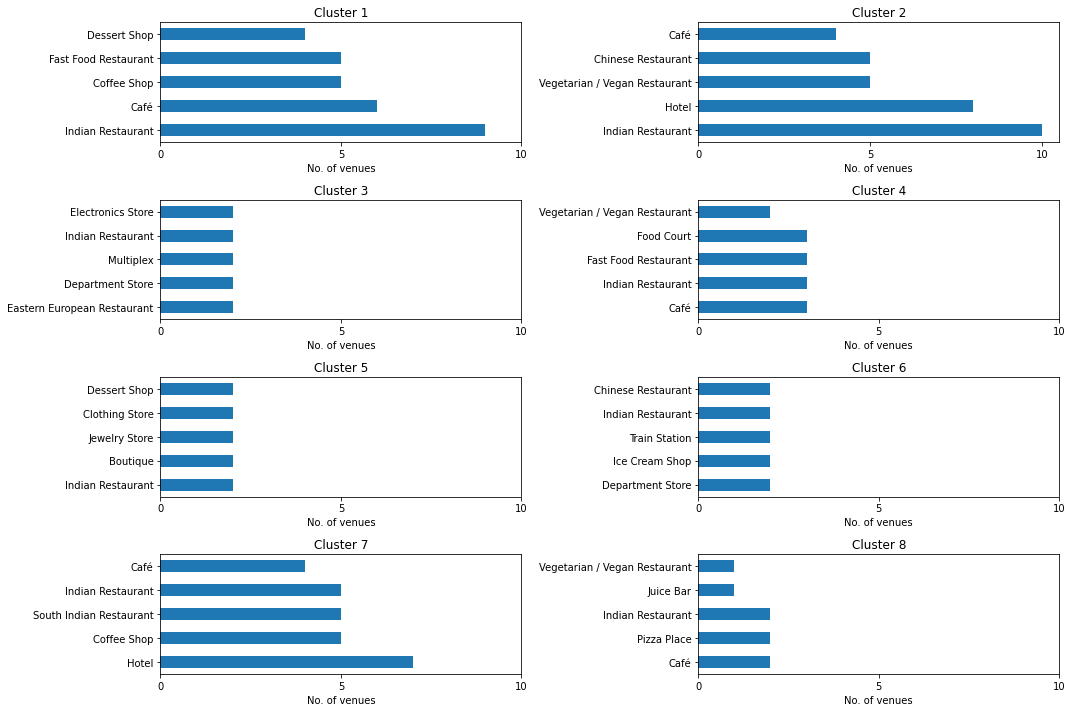

In [87]:
df_list = [venues1 ,venues2, venues3, venues4, venues5, venues6, venues7, venues8]
fig, axes = plt.subplots(4, 2)

count = 0
for r in range(4):
    for c in range(2):
        df_list[count].value_counts().head().plot.barh(ax = axes[r,c], width=0.5, figsize=(15,10))
        axes[r,c].set_title('Cluster {}'.format(count+1))
        plt.sca(axes[r, c])
        plt.xticks(np.arange(0, 15, 5))
        plt.xlabel('No. of venues')
        count += 1

fig.tight_layout()

This plot can be used to suggest valuable information to Business persons. Let's discuss a few examples considering they would like to start the following category of business.

#### 1. Hotel

The neighborhoods in cluster 2 has the greatest number of hotels, hence opening one here is not the best choice. So, is it best to open one at the neighborhoods in cluster 6 or 8? Not likely, since the place has a smaller number of food restaurants. Thus, an optimal place would be one which has less hotels, but also have restaurants and other places to explore. Considering all these facts, the best choice would be Cluster 1 and Cluster 7. such as the Adyar Bus Depot, Gemini Flyover neighborhoods.

#### 2. Shopping Mall

By using the same procedure as above, the suitable clusters would be the Cluster 1, Cluster 2 and Cluster 7, since it does not have shopping malls in any of the clusters and also it has many Hotels and Restaurants which gives an advantage.

#### 3. Departmental Stores

Repeat the procedure used in hotels. Although cluster 3 have departmental stores but cluster 4 and cluster 7 is also suitable neighborhood for business. Since we don't have enougf information from fouraquare

### Map of Chennai with the clusters superimposed on top

This map can be used to find a suitable location to start a new business based on the category.

In [83]:
# create map
chennai_clusters_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(chennai_merged['Neighborhood Latitude'], chennai_merged['Neighborhood Longitude'], chennai_merged['Neighborhood'], chennai_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(chennai_clusters_map)
       
chennai_clusters_map

This map can also be used to select a vast suggestion area for a particular type of business based on the category.

## Conclusion

Purpose of this project was to analyze the neighborhoods of Chennai and create a clustering model to suggest personals places to start a new business based on the category. The neighborhoods data was obtained from an online source and the Foursquare API was used to find the major venues in each neighborhood. But we found that many neighborhoods had less than 10 venues returned. In order to build a good Data Science model, we filtered out these locations. The remaining locations were used to create a clustering model. The best number of clusters i.e. 8 was obtained using the silhouette score. Each cluster was examined to find the most venue categories present, that defines the characteristics for that particular cluster.

A few examples for the applications that the clusters can be used for have also been discussed. A map showing the clusters have been provided. Both these can be used by stakeholders to decide the location for the particular type of business. A major drawback of this project was that the Foursquare API returned only few venues in each neighborhood. As a future improvement, better data sources can be used to obtain more venues in each neighborhood. This way the neighborhoods that were filtered out can be included in the clustering analysis to create a better decision model.

## Thank You

This notebook was dveloped by **Naidugari Manjunath**